In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from albumentations import *
from skimage.transform import resize

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model

import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
SHAPE = (224, 224, 3)
BATCH_SIZE = 24
EPOCHS = 100
N_SPLITS = 5
SEED = 1881
TRAIN_TEST_RATIO = 0.2

BASE_DIR     = "../../../data/BreaKHis_v1/histology_slides/breast/"
DATASET_MODE = ["40X", "100X", "200X", "400X"]

In [3]:
class BREAKHIST_DATASET:
    
    """
    input_shape           --> TUPLE.wanted image size
    batch_size            --> INT.yielding data size for every iteration
    orders                --> LIST.which images will be used. max=len(all_images). it can be used for K-fold(CV).
    base_dir              --> STR.the DIR which is include "benign" and "malignant" dirs.
    dataset_mode          --> STR. Which type of images will be used: "40X", "100X", "200X", "400X".
    seed                  --> INT. This allow to dataset generator to more reproduciable and it ensures that x and y are shuffled with compatible.
    augment               --> BOOL. Augment data or not.
    train_test_ratio      --> How much of data will be used as test set.
    ---------
    GENERAL_CLASSES       --> LIST.["benign", "malignant"]
    BENIGN_SUB_CLASSES    --> LIST.["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
    MALIGNANT_SUB_CLASSES --> LIST.["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
    """
    
    def __init__(self, input_shape, batch_size, orders, base_dir, dataset_mode, seed, train_test_ratio, augment=True):
        self.SHAPE                 = input_shape
        self.BATCH_SIZE            = batch_size
        self.arr                   = orders
        self.DATASET_MODE          = dataset_mode
        self.SEED                  = seed
        self.TT_RATIO              = train_test_ratio
        self.AUG                   = augment
        
        self.BASE_DIR              = base_dir
        self.GENERAL_CLASSES       = ["benign", "malignant"]
        self.BENIGN_SUB_CLASSES    = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
        self.MALIGNANT_SUB_CLASSES = ["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
        
        
    def get_paths_n_labels(self):

        x     = []
        label = []
        
        for data_mode in self.DATASET_MODE:
            for ix2, b in enumerate(self.BENIGN_SUB_CLASSES):
                path1 = self.BASE_DIR+"benign"+"/SOB/"+b
                for c in os.listdir(path1):
                    path2 = path1+"/"+c+"/"+data_mode
                    for img_name in os.listdir(path2):
                        path3 = path2+"/"+img_name
                        
                        # x
                        img_path = path3 

                        # y
                        main_targets = np.zeros((4), dtype=np.float32) # ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
                        for ix, benign_class in enumerate(self.BENIGN_SUB_CLASSES):
                            if benign_class in img_path:
                                main_targets[ix] = 1.
                                
                      
                        # Store the values
                        x.append(img_path)
                        label.append(main_targets)
        
        return x, label
    
    def __len__(self):
        return len(self.get_paths_n_labels()[0])
    
    def get_img(self, img_path):
        img = Image.open(img_path)
        return np.array(img)
    
    def augmenting(self, img):
        if self.AUG:
            augment = Compose([VerticalFlip(p=0.5),
                               HorizontalFlip(p=0.5),
                               RandomBrightnessContrast(p=0.3),
                               ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0.2, rotate_limit=20)])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    
    def resize_and_normalize(self, img):
        img = resize(img, self.SHAPE)
        return img
    
    def get_shuffled_data(self):
        img_paths, labels = self.get_paths_n_labels()

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
        
    def split_train_test(self, get):  # get=={"train","test"}
        img_paths, labels = self.get_shuffled_data()
        x_train, x_test, y_train, y_test = train_test_split(img_paths, labels, test_size=self.TT_RATIO, random_state=self.SEED)
        
        if get=='train':
            return x_train, y_train
        
        elif get=='test':
            return x_test, y_test
    
    def data_generator(self):
        img_paths, labels = self.split_train_test(get="train")
        
        while True:
            x = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y = np.empty((self.BATCH_SIZE, 4), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                # x
                img_path = img_paths[id_]
                img = self.get_img(img_path)
                img = self.augmenting(img)
                img = self.resize_and_normalize(img)
                  
                # y 
                label = labels[id_]
             
                # Store the values    
                x[ix] = img
                y[ix] = label

            yield x, y

[[[[0.6209099  0.5971704  0.5699996 ]
   [0.63389796 0.61852676 0.63190216]
   [0.5785605  0.5880493  0.59968925]
   ...
   [0.6023109  0.6312828  0.6384607 ]
   [0.5701287  0.5799698  0.55889136]
   [0.7172203  0.71928614 0.70524555]]

  [[0.6292936  0.606471   0.57384014]
   [0.5671     0.51472557 0.52536327]
   [0.29032737 0.26038823 0.30474   ]
   ...
   [0.62087053 0.6350403  0.6471551 ]
   [0.6600884  0.6592984  0.6407191 ]
   [0.6300683  0.6063988  0.5829722 ]]

  [[0.60674673 0.5619135  0.56465995]
   [0.31734288 0.2503239  0.29438463]
   [0.22933517 0.23397234 0.2554972 ]
   ...
   [0.67907476 0.67904633 0.68263304]
   [0.5929447  0.5942183  0.5590752 ]
   [0.4329066  0.41378894 0.39754683]]

  ...

  [[0.67421    0.63564426 0.6602044 ]
   [0.5924829  0.53901654 0.6009804 ]
   [0.5762342  0.53204656 0.5747702 ]
   ...
   [0.6376838  0.6115218  0.52414656]
   [0.6838848  0.67527133 0.6553834 ]
   [0.5357668  0.50138307 0.5375175 ]]

  [[0.5372527  0.49744618 0.519923  ]
   [0.5

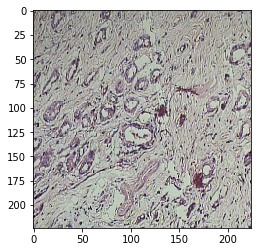

In [4]:
dataset = BREAKHIST_DATASET(SHAPE, 1, range(4), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)

for ix, data in enumerate(dataset.data_generator()):
    img, y = data
    print(img)
    print(img.shape)
    print("-"*10)
    print(y)
    print(y.shape)
    print("-"*10)
    print(img[0,:,:,:].shape)
    plt.imshow(img[0,:,:,:])
    plt.show()
    
    if ix==0:
        break

In [5]:
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [6]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [7]:
# copied from https://github.com/kobiso/CBAM-keras/blob/master/models/attention_module.py
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._keras_shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [8]:
# copied from https://gist.github.com/mjdietzx/5319e42637ed7ef095d430cb5c5e8c64
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [9]:
def create_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(4, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [10]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

global_average_pooling2d_2 (Glo (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, 1, 128)    0           global_average_pooling2d_2[0][0] 
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 1, 128)    0           global_max_pooling2d_2[0][0]     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 1, 16)     2064        reshape_3[0][0]                  
                                                                 reshape_4[0][0]                  
__________

In [11]:
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

for ix, (train_index, test_index) in enumerate(kf.split(range(len(dataset.split_train_test("train")[0])))):
                                               
    tg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, train_index, BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)
    vg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, test_index , BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False)
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.9,
                             cycle_length=10,
                             mult_factor=2.)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=[precision, recall, f1, 'acc'])

    model_ckpt = "BREAKHIST_FOLD_"+str(ix)+".h5"
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir='./log_'+str(ix), update_freq='epoch'), 
                 schedule] 
                                               
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index)//BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(test_index)//BATCH_SIZE,
                        callbacks=callbacks)


Epoch 1/100
 - 83s - loss: 1.2929 - precision: 0.5099 - recall: 0.2191 - f1: 0.3018 - acc: 0.4280 - val_loss: 1.0744 - val_precision: 0.5694 - val_recall: 0.2161 - val_f1: 0.3102 - val_acc: 0.5052

Epoch 00001: val_loss improved from inf to 1.07443, saving model to BREAKHIST_FOLD_0.h5
Epoch 2/100
 - 51s - loss: 1.2186 - precision: 0.5317 - recall: 0.2746 - f1: 0.3580 - acc: 0.4634 - val_loss: 1.2897 - val_precision: 0.5096 - val_recall: 0.3203 - val_f1: 0.3916 - val_acc: 0.4427

Epoch 00002: val_loss did not improve from 1.07443
Epoch 3/100
 - 47s - loss: 1.0595 - precision: 0.6339 - recall: 0.3775 - f1: 0.4695 - acc: 0.5499 - val_loss: 2.4888 - val_precision: 0.3447 - val_recall: 0.2891 - val_f1: 0.3140 - val_acc: 0.3203

Epoch 00003: val_loss did not improve from 1.07443
Epoch 4/100
 - 43s - loss: 0.9734 - precision: 0.6480 - recall: 0.4583 - f1: 0.5351 - acc: 0.5865 - val_loss: 1.0576 - val_precision: 0.5968 - val_recall: 0.4609 - val_f1: 0.5195 - val_acc: 0.5417

Epoch 00004: val_l

Epoch 00064: val_loss improved from 0.28331 to 0.27238, saving model to BREAKHIST_FOLD_0.h5
Epoch 65/100
 - 68s - loss: 0.2368 - precision: 0.9203 - recall: 0.9053 - f1: 0.9126 - acc: 0.9135 - val_loss: 1.1534 - val_precision: 0.6479 - val_recall: 0.6146 - val_f1: 0.6304 - val_acc: 0.6328

Epoch 00065: val_loss did not improve from 0.27238
Epoch 66/100
 - 115s - loss: 0.3710 - precision: 0.8661 - recall: 0.8510 - f1: 0.8584 - acc: 0.8580 - val_loss: 3.7212 - val_precision: 0.2083 - val_recall: 0.1979 - val_f1: 0.2029 - val_acc: 0.2109

Epoch 00066: val_loss did not improve from 0.27238
Epoch 67/100
 - 77s - loss: 0.3604 - precision: 0.8801 - recall: 0.8567 - f1: 0.8681 - acc: 0.8693 - val_loss: 1.1071 - val_precision: 0.6331 - val_recall: 0.5990 - val_f1: 0.6153 - val_acc: 0.6146

Epoch 00067: val_loss did not improve from 0.27238
Epoch 68/100
 - 41s - loss: 0.3139 - precision: 0.8904 - recall: 0.8699 - f1: 0.8799 - acc: 0.8813 - val_loss: 0.8893 - val_precision: 0.6782 - val_recall: 0


Epoch 00028: val_loss did not improve from 0.15085
Epoch 29/100
 - 41s - loss: 0.3112 - precision: 0.8898 - recall: 0.8788 - f1: 0.8842 - acc: 0.8832 - val_loss: 0.3090 - val_precision: 0.8883 - val_recall: 0.8750 - val_f1: 0.8815 - val_acc: 0.8828

Epoch 00029: val_loss did not improve from 0.15085
Epoch 30/100
 - 41s - loss: 0.2428 - precision: 0.9069 - recall: 0.8914 - f1: 0.8989 - acc: 0.9015 - val_loss: 0.2130 - val_precision: 0.9233 - val_recall: 0.9141 - val_f1: 0.9185 - val_acc: 0.9141

Epoch 00030: val_loss did not improve from 0.15085
Epoch 31/100
 - 41s - loss: 0.2908 - precision: 0.8938 - recall: 0.8775 - f1: 0.8855 - acc: 0.8851 - val_loss: 0.5999 - val_precision: 0.8172 - val_recall: 0.7891 - val_f1: 0.8027 - val_acc: 0.8021

Epoch 00031: val_loss did not improve from 0.15085
Epoch 32/100
 - 41s - loss: 0.2472 - precision: 0.9164 - recall: 0.9021 - f1: 0.9091 - acc: 0.9104 - val_loss: 0.3378 - val_precision: 0.8564 - val_recall: 0.8411 - val_f1: 0.8486 - val_acc: 0.8542



Epoch 00061: val_loss did not improve from 0.11685
Epoch 62/100
 - 41s - loss: 0.2546 - precision: 0.9059 - recall: 0.8946 - f1: 0.9001 - acc: 0.8990 - val_loss: 0.6688 - val_precision: 0.7525 - val_recall: 0.7370 - val_f1: 0.7446 - val_acc: 0.7552

Epoch 00062: val_loss did not improve from 0.11685
Epoch 63/100
 - 41s - loss: 0.1846 - precision: 0.9464 - recall: 0.9362 - f1: 0.9412 - acc: 0.9407 - val_loss: 0.2009 - val_precision: 0.9315 - val_recall: 0.9245 - val_f1: 0.9279 - val_acc: 0.9297

Epoch 00063: val_loss did not improve from 0.11685
Epoch 64/100
 - 41s - loss: 0.1903 - precision: 0.9330 - recall: 0.9249 - f1: 0.9288 - acc: 0.9299 - val_loss: 0.1679 - val_precision: 0.9398 - val_recall: 0.9349 - val_f1: 0.9373 - val_acc: 0.9401

Epoch 00064: val_loss did not improve from 0.11685
Epoch 65/100
 - 41s - loss: 0.1674 - precision: 0.9458 - recall: 0.9369 - f1: 0.9412 - acc: 0.9400 - val_loss: 0.3242 - val_precision: 0.8853 - val_recall: 0.8411 - val_f1: 0.8623 - val_acc: 0.8646



Epoch 00094: val_loss did not improve from 0.11685
Epoch 95/100
 - 41s - loss: 0.1575 - precision: 0.9396 - recall: 0.9324 - f1: 0.9359 - acc: 0.9362 - val_loss: 0.9396 - val_precision: 0.7355 - val_recall: 0.7109 - val_f1: 0.7228 - val_acc: 0.7396

Epoch 00095: val_loss did not improve from 0.11685
Epoch 96/100
 - 41s - loss: 0.1982 - precision: 0.9230 - recall: 0.9160 - f1: 0.9194 - acc: 0.9192 - val_loss: 1.3343 - val_precision: 0.6411 - val_recall: 0.6224 - val_f1: 0.6315 - val_acc: 0.6250

Epoch 00096: val_loss did not improve from 0.11685
Epoch 97/100
 - 41s - loss: 0.1745 - precision: 0.9390 - recall: 0.9331 - f1: 0.9360 - acc: 0.9362 - val_loss: 0.6553 - val_precision: 0.7829 - val_recall: 0.7526 - val_f1: 0.7672 - val_acc: 0.7552

Epoch 00097: val_loss did not improve from 0.11685
Epoch 98/100
 - 41s - loss: 0.1774 - precision: 0.9418 - recall: 0.9318 - f1: 0.9367 - acc: 0.9381 - val_loss: 1.0149 - val_precision: 0.6989 - val_recall: 0.6693 - val_f1: 0.6834 - val_acc: 0.6823



Epoch 00026: val_loss did not improve from 0.08360
Epoch 27/100
 - 41s - loss: 0.1733 - precision: 0.9404 - recall: 0.9343 - f1: 0.9373 - acc: 0.9375 - val_loss: 0.0955 - val_precision: 0.9687 - val_recall: 0.9687 - val_f1: 0.9687 - val_acc: 0.9687

Epoch 00027: val_loss did not improve from 0.08360
Epoch 28/100
 - 41s - loss: 0.1660 - precision: 0.9473 - recall: 0.9413 - f1: 0.9442 - acc: 0.9444 - val_loss: 0.7547 - val_precision: 0.7503 - val_recall: 0.7422 - val_f1: 0.7462 - val_acc: 0.7526

Epoch 00028: val_loss did not improve from 0.08360
Epoch 29/100
 - 41s - loss: 0.2055 - precision: 0.9258 - recall: 0.9217 - f1: 0.9237 - acc: 0.9230 - val_loss: 0.1928 - val_precision: 0.9189 - val_recall: 0.9167 - val_f1: 0.9178 - val_acc: 0.9167

Epoch 00029: val_loss did not improve from 0.08360
Epoch 30/100
 - 40s - loss: 0.1619 - precision: 0.9398 - recall: 0.9369 - f1: 0.9383 - acc: 0.9388 - val_loss: 0.1107 - val_precision: 0.9583 - val_recall: 0.9557 - val_f1: 0.9570 - val_acc: 0.9557



Epoch 00059: val_loss did not improve from 0.04365
Epoch 60/100
 - 40s - loss: 0.1356 - precision: 0.9569 - recall: 0.9533 - f1: 0.9551 - acc: 0.9558 - val_loss: 1.0572 - val_precision: 0.6805 - val_recall: 0.6562 - val_f1: 0.6679 - val_acc: 0.6745

Epoch 00060: val_loss did not improve from 0.04365
Epoch 61/100
 - 40s - loss: 0.2071 - precision: 0.9272 - recall: 0.9186 - f1: 0.9228 - acc: 0.9249 - val_loss: 1.0874 - val_precision: 0.7002 - val_recall: 0.6875 - val_f1: 0.6937 - val_acc: 0.6901

Epoch 00061: val_loss did not improve from 0.04365
Epoch 62/100
 - 41s - loss: 0.2020 - precision: 0.9256 - recall: 0.9186 - f1: 0.9220 - acc: 0.9230 - val_loss: 0.4197 - val_precision: 0.8576 - val_recall: 0.8464 - val_f1: 0.8518 - val_acc: 0.8542

Epoch 00062: val_loss did not improve from 0.04365
Epoch 63/100
 - 41s - loss: 0.1265 - precision: 0.9568 - recall: 0.9520 - f1: 0.9544 - acc: 0.9545 - val_loss: 0.0490 - val_precision: 0.9792 - val_recall: 0.9792 - val_f1: 0.9792 - val_acc: 0.9792



Epoch 00092: val_loss did not improve from 0.03816
Epoch 93/100
 - 41s - loss: 0.1219 - precision: 0.9637 - recall: 0.9558 - f1: 0.9596 - acc: 0.9596 - val_loss: 0.2526 - val_precision: 0.8932 - val_recall: 0.8932 - val_f1: 0.8932 - val_acc: 0.8932

Epoch 00093: val_loss did not improve from 0.03816
Epoch 94/100
 - 40s - loss: 0.2058 - precision: 0.9293 - recall: 0.9217 - f1: 0.9254 - acc: 0.9242 - val_loss: 1.1611 - val_precision: 0.6257 - val_recall: 0.5443 - val_f1: 0.5814 - val_acc: 0.5781

Epoch 00094: val_loss did not improve from 0.03816
Epoch 95/100
 - 40s - loss: 0.1818 - precision: 0.9372 - recall: 0.9337 - f1: 0.9354 - acc: 0.9356 - val_loss: 0.4599 - val_precision: 0.8524 - val_recall: 0.8281 - val_f1: 0.8398 - val_acc: 0.8411

Epoch 00095: val_loss did not improve from 0.03816
Epoch 96/100
 - 40s - loss: 0.1762 - precision: 0.9403 - recall: 0.9331 - f1: 0.9366 - acc: 0.9388 - val_loss: 0.3210 - val_precision: 0.8690 - val_recall: 0.8464 - val_f1: 0.8572 - val_acc: 0.8646



Epoch 00025: val_loss did not improve from 0.05886
Epoch 26/100
 - 41s - loss: 0.2071 - precision: 0.9221 - recall: 0.9129 - f1: 0.9174 - acc: 0.9186 - val_loss: 0.2716 - val_precision: 0.9189 - val_recall: 0.9167 - val_f1: 0.9178 - val_acc: 0.9167

Epoch 00026: val_loss did not improve from 0.05886
Epoch 27/100
 - 41s - loss: 0.1409 - precision: 0.9591 - recall: 0.9533 - f1: 0.9561 - acc: 0.9552 - val_loss: 0.0622 - val_precision: 0.9870 - val_recall: 0.9844 - val_f1: 0.9856 - val_acc: 0.9870

Epoch 00027: val_loss did not improve from 0.05886
Epoch 28/100
 - 41s - loss: 0.1023 - precision: 0.9659 - recall: 0.9615 - f1: 0.9636 - acc: 0.9634 - val_loss: 0.2805 - val_precision: 0.8831 - val_recall: 0.8646 - val_f1: 0.8736 - val_acc: 0.8776

Epoch 00028: val_loss did not improve from 0.05886
Epoch 29/100
 - 41s - loss: 0.1338 - precision: 0.9506 - recall: 0.9495 - f1: 0.9500 - acc: 0.9501 - val_loss: 0.3416 - val_precision: 0.9017 - val_recall: 0.8776 - val_f1: 0.8893 - val_acc: 0.8958



Epoch 00058: val_loss did not improve from 0.05293
Epoch 59/100
 - 41s - loss: 0.0950 - precision: 0.9694 - recall: 0.9659 - f1: 0.9676 - acc: 0.9678 - val_loss: 0.2402 - val_precision: 0.9062 - val_recall: 0.9062 - val_f1: 0.9062 - val_acc: 0.9062

Epoch 00059: val_loss did not improve from 0.05293
Epoch 60/100
 - 41s - loss: 0.1022 - precision: 0.9614 - recall: 0.9596 - f1: 0.9605 - acc: 0.9602 - val_loss: 1.4556 - val_precision: 0.6488 - val_recall: 0.6224 - val_f1: 0.6351 - val_acc: 0.6380

Epoch 00060: val_loss did not improve from 0.05293
Epoch 61/100
 - 41s - loss: 0.1648 - precision: 0.9445 - recall: 0.9381 - f1: 0.9412 - acc: 0.9407 - val_loss: 1.0400 - val_precision: 0.7954 - val_recall: 0.7786 - val_f1: 0.7868 - val_acc: 0.7891

Epoch 00061: val_loss did not improve from 0.05293
Epoch 62/100
 - 41s - loss: 0.1158 - precision: 0.9599 - recall: 0.9539 - f1: 0.9569 - acc: 0.9558 - val_loss: 0.3595 - val_precision: 0.8923 - val_recall: 0.8880 - val_f1: 0.8901 - val_acc: 0.8880



Epoch 00091: val_loss did not improve from 0.05293
Epoch 92/100
 - 41s - loss: 0.0702 - precision: 0.9771 - recall: 0.9735 - f1: 0.9752 - acc: 0.9747 - val_loss: 0.4671 - val_precision: 0.8307 - val_recall: 0.8307 - val_f1: 0.8307 - val_acc: 0.8307

Epoch 00092: val_loss did not improve from 0.05293
Epoch 93/100
 - 41s - loss: 0.0956 - precision: 0.9701 - recall: 0.9646 - f1: 0.9673 - acc: 0.9684 - val_loss: 0.4470 - val_precision: 0.8409 - val_recall: 0.8385 - val_f1: 0.8397 - val_acc: 0.8385

Epoch 00093: val_loss did not improve from 0.05293
Epoch 94/100
 - 41s - loss: 0.1249 - precision: 0.9542 - recall: 0.9470 - f1: 0.9505 - acc: 0.9520 - val_loss: 1.3657 - val_precision: 0.6225 - val_recall: 0.5859 - val_f1: 0.6033 - val_acc: 0.6120

Epoch 00094: val_loss did not improve from 0.05293
Epoch 95/100
 - 41s - loss: 0.2053 - precision: 0.9270 - recall: 0.9211 - f1: 0.9239 - acc: 0.9242 - val_loss: 0.4514 - val_precision: 0.8377 - val_recall: 0.8333 - val_f1: 0.8355 - val_acc: 0.8333



Epoch 00024: val_loss did not improve from 0.02577
Epoch 25/100
 - 41s - loss: 0.1210 - precision: 0.9588 - recall: 0.9545 - f1: 0.9566 - acc: 0.9552 - val_loss: 0.1365 - val_precision: 0.9557 - val_recall: 0.9557 - val_f1: 0.9557 - val_acc: 0.9557

Epoch 00025: val_loss did not improve from 0.02577
Epoch 26/100
 - 41s - loss: 0.1057 - precision: 0.9626 - recall: 0.9583 - f1: 0.9604 - acc: 0.9596 - val_loss: 0.3361 - val_precision: 0.8656 - val_recall: 0.8516 - val_f1: 0.8583 - val_acc: 0.8594

Epoch 00026: val_loss did not improve from 0.02577
Epoch 27/100
 - 41s - loss: 0.0937 - precision: 0.9688 - recall: 0.9640 - f1: 0.9663 - acc: 0.9659 - val_loss: 0.0365 - val_precision: 0.9870 - val_recall: 0.9870 - val_f1: 0.9870 - val_acc: 0.9870

Epoch 00027: val_loss did not improve from 0.02577
Epoch 28/100
 - 41s - loss: 0.1086 - precision: 0.9614 - recall: 0.9583 - f1: 0.9598 - acc: 0.9602 - val_loss: 0.2739 - val_precision: 0.8904 - val_recall: 0.8880 - val_f1: 0.8892 - val_acc: 0.8880



Epoch 00057: val_loss did not improve from 0.01741
Epoch 58/100
 - 41s - loss: 0.0721 - precision: 0.9791 - recall: 0.9754 - f1: 0.9772 - acc: 0.9779 - val_loss: 0.0291 - val_precision: 0.9922 - val_recall: 0.9922 - val_f1: 0.9922 - val_acc: 0.9922

Epoch 00058: val_loss did not improve from 0.01741
Epoch 59/100
 - 41s - loss: 0.0670 - precision: 0.9798 - recall: 0.9773 - f1: 0.9785 - acc: 0.9779 - val_loss: 0.1144 - val_precision: 0.9609 - val_recall: 0.9609 - val_f1: 0.9609 - val_acc: 0.9609

Epoch 00059: val_loss did not improve from 0.01741
Epoch 60/100
 - 41s - loss: 0.1089 - precision: 0.9588 - recall: 0.9552 - f1: 0.9569 - acc: 0.9577 - val_loss: 0.1897 - val_precision: 0.9397 - val_recall: 0.9323 - val_f1: 0.9359 - val_acc: 0.9323

Epoch 00060: val_loss did not improve from 0.01741
Epoch 61/100
 - 41s - loss: 0.1543 - precision: 0.9436 - recall: 0.9407 - f1: 0.9421 - acc: 0.9426 - val_loss: 0.2568 - val_precision: 0.8906 - val_recall: 0.8906 - val_f1: 0.8906 - val_acc: 0.8906



Epoch 00090: val_loss did not improve from 0.01741
Epoch 91/100
 - 41s - loss: 0.0598 - precision: 0.9791 - recall: 0.9773 - f1: 0.9782 - acc: 0.9792 - val_loss: 0.0803 - val_precision: 0.9686 - val_recall: 0.9609 - val_f1: 0.9647 - val_acc: 0.9635

Epoch 00091: val_loss did not improve from 0.01741
Epoch 92/100
 - 41s - loss: 0.0680 - precision: 0.9804 - recall: 0.9792 - f1: 0.9798 - acc: 0.9792 - val_loss: 0.1025 - val_precision: 0.9557 - val_recall: 0.9531 - val_f1: 0.9544 - val_acc: 0.9557

Epoch 00092: val_loss did not improve from 0.01741
Epoch 93/100
 - 41s - loss: 0.0984 - precision: 0.9707 - recall: 0.9672 - f1: 0.9689 - acc: 0.9697 - val_loss: 0.9499 - val_precision: 0.7341 - val_recall: 0.7318 - val_f1: 0.7329 - val_acc: 0.7344

Epoch 00093: val_loss did not improve from 0.01741
Epoch 94/100
 - 41s - loss: 0.1131 - precision: 0.9645 - recall: 0.9615 - f1: 0.9630 - acc: 0.9634 - val_loss: 0.7176 - val_precision: 0.7970 - val_recall: 0.7865 - val_f1: 0.7915 - val_acc: 0.7891


In [11]:
def get_test_data():
    gen = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, range(1), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False).split_train_test("test")
                       
    x = np.empty((len(gen[0]),)+SHAPE, dtype=np.float32)
    y = np.empty((len(gen[1]), 4), dtype=np.float32)
    
    for ix, path in tqdm(enumerate(gen[0])):
        img = np.array(Image.open(gen[0][ix]))
        img = resize(img, SHAPE)

        label = gen[1][ix]

        x[ix] = img
        y[ix] = label
        
    return x, y

In [12]:
x, y = get_test_data()

496it [00:15, 31.09it/s]


In [13]:
# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

In [14]:
models = []
for i in range(5):
    model = load_model("BREAKHIST_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    print(model.evaluate(x, y, verbose=0))
    models.append(model)

[0.1933774491471629, 0.9213059294608331, 0.9193548387096774, 0.9203148407320823, 0.9193548387096774]
[0.1565020848666468, 0.93093131819079, 0.9254032258064516, 0.9281233376072299, 0.9314516129032258]
[0.16519439893384133, 0.9553156398957775, 0.9475806451612904, 0.9513547670456671, 0.9495967741935484]
[0.16225883172404382, 0.9415322580645161, 0.9415322580645161, 0.9415322061507932, 0.9415322580645161]
[0.12620947630174698, 0.9556451612903226, 0.9556451612903226, 0.9556451055311388, 0.9556451612903226]


In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("ALL_DATA_4_CLASS_BENIGN - confusion matrix - 5. FOLD.jpg", dpi=150)
    plt.show()

Accuracy: 0.9556451612903226, F1_Score: 0.9503764875865299, Precision: 0.9486499294498788, Recall: 0.9523404369873982


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       101
           1       0.98      0.96      0.97       207
           2       0.91      0.90      0.91        81
           3       0.95      0.98      0.96       107

   micro avg       0.96      0.96      0.96       496
   macro avg       0.95      0.95      0.95       496
weighted avg       0.96      0.96      0.96       496
 samples avg       0.96      0.96      0.96       496





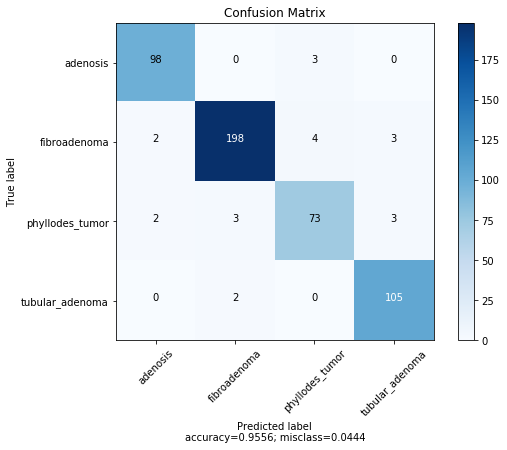

In [16]:
y_preds = threshold_arr(models[4].predict(x, verbose=0))

results = precision_recall_fscore_support(y, y_preds ,average='macro')
acc = accuracy_score(y, y_preds)

print("Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"],
                      title        = "Confusion Matrix")

In [18]:
import time
for i in range(5): 
    img = np.array(Image.open(BASE_DIR+"benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-009.png"))
    x = resize(img, SHAPE)
    x = x.reshape((1,) + x.shape) 
    start = time.time()
    prediction = models[4].predict(x, batch_size=1)
    finish = time.time()
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[1. 0. 0. 0.]]
132.45820999145508 ms
***
[[1. 0. 0. 0.]]
9.023666381835938 ms
***
[[1. 0. 0. 0.]]
8.058547973632812 ms
***
[[1. 0. 0. 0.]]
9.052515029907227 ms
***
[[1. 0. 0. 0.]]
8.059501647949219 ms
***
